In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time

In [2]:
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')

In [3]:
from scripts.core import TN_utils, models, compiling, optimizers
reload(TN_utils)

Using gpu device 1: Tesla M2070 (CNMeM is disabled, CuDNN not available)


<module 'scripts.core.TN_utils' from '/home/matsui-k/projects/d-rcn/scripts/core/TN_utils.pyc'>

In [4]:
fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(i_order=2, i_indiv=0, mask_thresh=0.5)

(430080, 37, 18) (430080, 18) (430080,)


In [5]:
data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(fe_vec, gt_vec, mask_vec)

(21485, 18, 37)
(21485, 18)
(5372, 18, 37)
(5372, 18)


In [14]:
rcn_2layer = models.Rcn2layer_wo_bn(
    n_tensors_list=[fe_vec.shape[1], 1024],
    func_key_list=["relu", "linear"],
    l2_reg=0.,
    gamma_scale=10**-2,
    drop_list=[1., 1.],
    bias_scale=0.)
                            
result = compiling.compile_bn(
    data_set=data_set,
    model=rcn_2layer,
    make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, s_input, s_target, s_test_input, s_test_target, param_list= result

batch_size = 1024
N = s_input.get_value(borrow=True).shape[0]
batch_size = batch_size
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = data_set[2].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 301
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.99
        print i_epoch, training_error, test_error
print time.clock() - start_time

/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:67: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 8 is not part of the computational graph needed to compute the outputs: beta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:67: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 9 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:74: UserWar

0 0.0327825546265 0.034330483526
10 0.0265663042665 0.0258796159178
20 0.0240739490837 0.0229911264032
30 0.0236786268651 0.0241942554712
40 0.022261345759 0.0216326210648
50 0.0196795202792 0.0228413697332
60 0.0196522567421 0.0196892656386
70 0.0194835066795 0.0201586261392
80 0.0184314008802 0.0213441792876
90 0.0195340104401 0.0196484997869
100 0.0171258021146 0.018553506583
110 0.0163393486291 0.0189431104809
120 0.0162995774299 0.0179696176201
130 0.0160853285342 0.0186302978545
140 0.0157506037503 0.0183015242219
150 0.0161404013634 0.0198005381972
160 0.0155149949715 0.0203498862684
170 0.0146006708965 0.0177557896823
180 0.014468616806 0.0201780777425
190 0.0144426953048 0.0183217823505
200 0.0136981904507 0.01705394499
210 0.0135383727029 0.0189793147147
220 0.0136028220877 0.0177644230425
230 0.013953609392 0.0172893833369
240 0.013532797806 0.0203730296344
250 0.0139152724296 0.0170785188675
260 0.0128060514107 0.01752069965
270 0.0127684511244 0.0169890765101
280 0.0138186

/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:74: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 4 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')


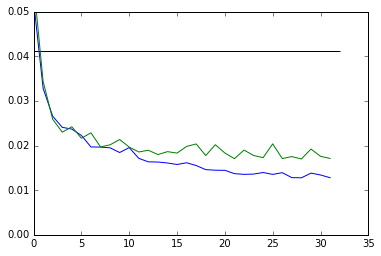

In [15]:
plt.plot(training_error_array)
plt.plot(test_error_array)
plt.ylim(0, 0.05)
plt.hlines(0.0411, 0, training_error_array.shape[0])

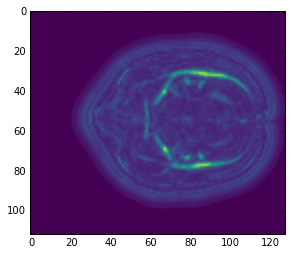

In [16]:
pred_train = TN_utils.predict_original_feature(f_output, fe_vec, norm_coef)
pred_train_vol = pred_train.reshape(vol_shape+(pred_train.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_train_vol, axis=0)[:, :, 15])

(430080, 37, 18)


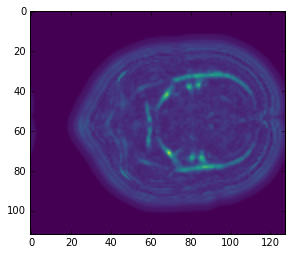

In [19]:
fe_test = TN_utils.load_hardi(i_order=2, i_indiv=1, only_feature=True)
pred_test = TN_utils.predict_original_feature(f_output, fe_test, norm_coef)
pred_test_vol = pred_test.reshape(vol_shape+(pred_test.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_test_vol, axis=0)[:, :, 15])

In [21]:
sio.savemat('../../../results/hardi_in_ex/Jun7/a4_all_train_1506.mat', {'pred' : pred_train_vol}) 
sio.savemat('../../../results/hardi_in_ex/Jun7/a4_all_test_1507.mat', {'pred' : pred_test_vol})